In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import argparse
import os

import numpy as np
np.random.seed(2016)
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray   

In [3]:
def create_fcn(input_size):
    inputs = Input((3, input_size[1], input_size[0]))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool5)
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv6), conv5])
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv7), conv4])
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv8), conv3])
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv9)

    up10 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv9), conv2])
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv10)

    up11 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv10), conv1])
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv11)

    conv12 = Conv2D(1, (1, 1), activation='sigmoid', data_format='channels_first')(conv11)
    #conv12 = Conv2D(1, 1, 1)(conv11)
    
    fcn = Model(input=inputs, output=conv12)

    return fcn

In [4]:
if __name__ == '__main__':

    dim_ordering = 'channels_first'
    target_size = (224, 224)
    
    fpaths_xs_test = list_pictures_in_multidir(['./dataset/test/'])    
    
    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, 
                               target_size=target_size,
                               dim_ordering=dim_ordering)
    print('==> ' + str(len(X_test)) +  ' test images loaded')
    print(X_test.shape)

    # トレーニング時に計算した平均・標準偏差をロード
    fname_stats = 'stats.npy.npz'
    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    print('globally normalizing data...')
    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

    # モデルを作成
    # （model_from_json()を使って保存してある構造を読み込むことも可能）
    print('creating model...')
    model = create_fcn(target_size)
    model.summary()

..............==> 14 test images loaded
(14, 3, 224, 224)
loading mean and standard deviation from stats.npy.npz...
==> mean: [ 212.35101318  174.92796326  189.6602478 ]
==> std : [ 58.92221451  57.95788956  58.58301926]
globally normalizing data...
==> done
creating model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 224, 224)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 224, 224)  9248        conv2d_1[0][0]                   
________________

/home/nakazawa/anaconda3/envs/py3-tf2-keras2/lib/python3.5/site-packages/ipykernel/__main__.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [5]:
    # 学習済みの重みをロード
    dpath_checkpoints = './checkpoints/'
    epoch = 19
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    model.load_weights(fpath_weights)
    print('==> done')

==> done


In [6]:
    # テストを開始
    outputs = model.predict(X_test)

    # 出力を画像として保存
    dname_outputs = './outputs/'
    dpath_this = '.'
    dpath_outputs = os.path.join(dpath_this, dname_outputs)
    if not os.path.isdir(dpath_outputs):
        os.mkdir(dpath_outputs)

    print('saving outputs as images...')
    n = 0
    for i, array in enumerate(outputs):
        array = np.where(array > 0.5, 1, 0) # 二値に変換
        array = array.astype(np.float32)
        img_out = array_to_img(array, dim_ordering)
        fpath_out = os.path.join(dpath_outputs, "%05d.jpg"%(n))
        img_out.save(fpath_out)
        n = n + 1
    print('==> done')

saving outputs as images...
==> done


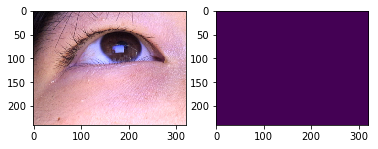

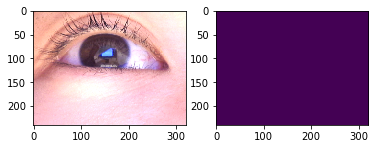

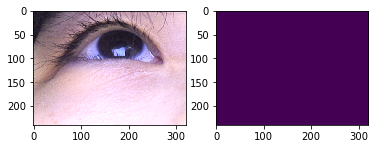

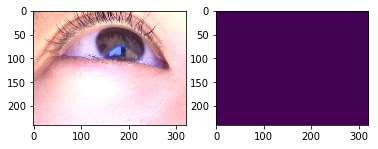

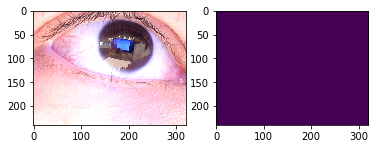

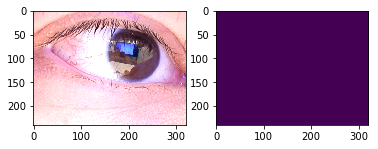

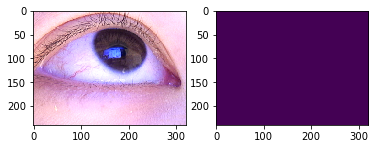

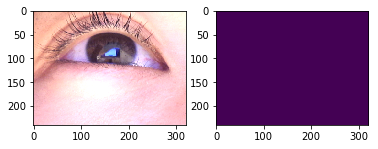

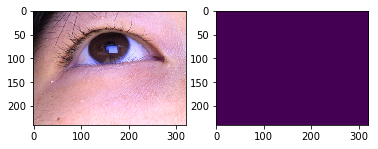

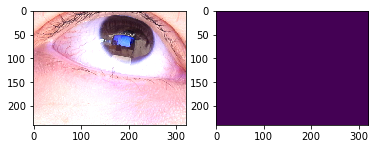

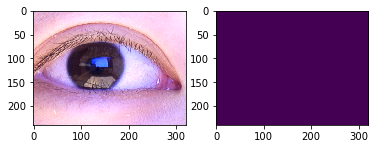

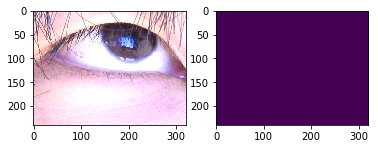

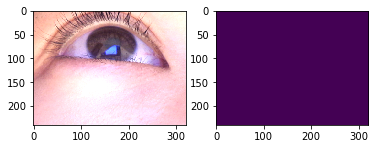

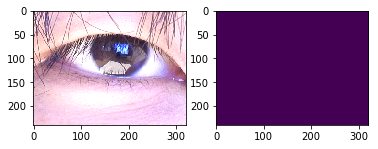

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

n = 0
for i in range(len(fpaths_xs_test)):
    im1 = Image.open(fpaths_xs_test[i])
    im1 = im1.resize((320,240))    
    im2 = Image.open(os.path.join(dname_outputs, "%05d.jpg"%(n)))
    im2 = im2.resize((320,240))
    plt.subplot(1,2,1)
    plt.imshow(im1)
    plt.subplot(1,2,2)
    plt.imshow(im2)
    plt.show()
#    print(fpaths_xs_test[i])
#    print(os.path.join(dname_outputs, "%05d.jpg"%(n)))
    n = n + 1